<a href="https://colab.research.google.com/github/amandeepsaini/green-screen-anywhere/blob/main/Inference_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [48]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import random
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Helper Functions

In [52]:
def show_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

def show_img_mult(imgs, rows=5, columns=5):
  num_imgs = len(imgs)
  fig = plt.figure(figsize=(20,20))
  for i in range(num_imgs):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
  plt.show()

# Obtained and adapted from https://stackoverflow.com/questions/51702749/numpy-array-as-video-in-jupyter-notebook
def show_video(video, framerate=20, figsize=(5,5)):
    # video should be np array with shape (frames, height, width, channels)

    fig = plt.figure(figsize=figsize)
    im = plt.imshow(cv2.cvtColor(video[0,:,:,:], cv2.COLOR_BGR2RGB))

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(cv2.cvtColor(video[0,:,:,:], cv2.COLOR_BGR2RGB))

    def animate(i):
        im.set_data(cv2.cvtColor(video[i,:,:,:], cv2.COLOR_BGR2RGB))
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                interval=int(1000/framerate))
    return HTML(anim.to_html5_video())


In [5]:
def square_crop(img, start_y=0, start_x=0, resize_to=None):
  h, w, c = img.shape

  if h > w:
    start_y = max(start_y, 0)
    end_y = min(start_y + w, h)
    start_y = end_y - w
    img_crop = img[start_y:end_y]

  else:
    start_x = max(start_x, 0)
    end_x = min(start_x + h, w)
    start_x = end_x - h
    img_crop = img[:,start_x:end_x]

  if resize_to is not None:
    img_crop = cv2.resize(img_crop, (resize_to, resize_to))

  return img_crop

In [42]:
def get_video_frames(vid_filepath, num_frames=-1, skip_frames=0, start_y=350, resize_to=160, bg_frame_num=5):
    vid_cap = cv2.VideoCapture(vid_filepath)
    vid_frames = []
    bg_frame = None
    total_frames = vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)
    max_frames = int(total_frames/(skip_frames + 1))
    if num_frames == -1:
        num_frames = max_frames
    else:
        num_frames = min(num_frames, max_frames)

    for i in tqdm(range(num_frames)):
        for skip in range(skip_frames):
            ret, frame = vid_cap.read()

        ret, frame = vid_cap.read()
        if frame is None:
            break
        image = square_crop(frame, start_y=start_y, resize_to=resize_to).astype(np.float32)/255.
        vid_frames.append(image)
        # vid_frames.append(frame)
    
    # check for valid frame number
    if bg_frame_num >= 0 & bg_frame_num <= total_frames:
        # set frame position
        vid_cap.set(cv2.CAP_PROP_POS_FRAMES,bg_frame_num)
        ret, frame = vid_cap.read()
        bg_frame = square_crop(frame, start_y=start_y, resize_to=resize_to).astype(np.float32)/255.


    return vid_frames, bg_frame

# Prepare Data

In [4]:
ds_root = "/content/gdrive/MyDrive/Colab Notebooks/Green Screen/Datasets/Test/test1"
bg_dir = os.path.join(ds_root, "bgs")
test_dir = os.path.join(ds_root, "test_images")

sample_bgs = []
test_imgs = []

for filename in os.listdir(bg_dir):
  sample_bgs.append(cv2.imread(os.path.join(bg_dir, filename)))

for filename in os.listdir(test_dir):
  test_imgs.append(cv2.imread(os.path.join(test_dir, filename)))



In [7]:
bgs_cropped = [square_crop(img, start_y=350, resize_to=160).astype(np.float32)/255. for img in sample_bgs]
test_imgs_cropped = [square_crop(img, start_y=350, resize_to=160).astype(np.float32)/255. for img in test_imgs]

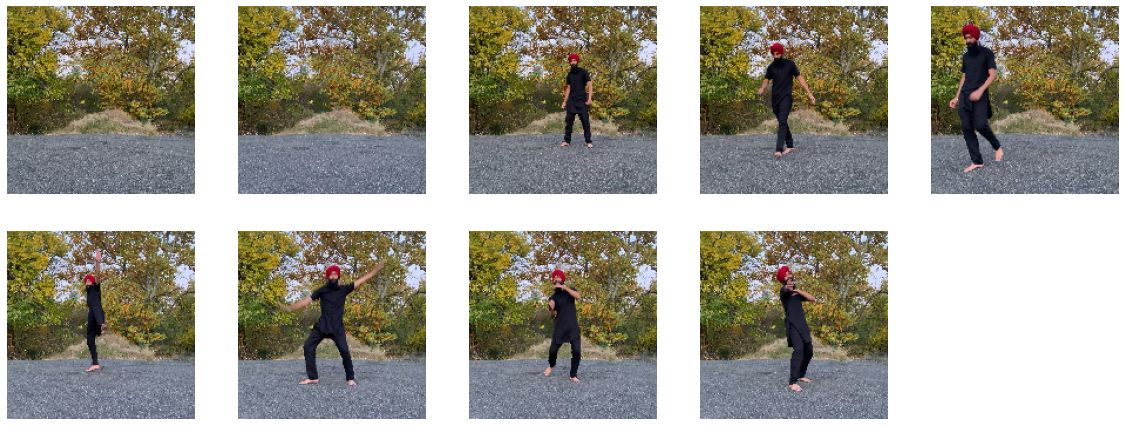

In [10]:
show_img_mult(bgs_cropped + test_imgs_cropped)

# Prepare Model

In [6]:
# model_dir = "/content/gdrive/MyDrive/Colab Notebooks/Green Screen/models/model5_20epoch/"

model_dir = "/content/gdrive/MyDrive/Colab Notebooks/Green Screen/models/model5_30epoch_advDataGen/"

model = keras.models.load_model(model_dir)

# Execute

In [8]:
output = model.predict([test_imgs_cropped[0].reshape((1,160,160,3)), bgs_cropped[0].reshape((1,160,160,3))])

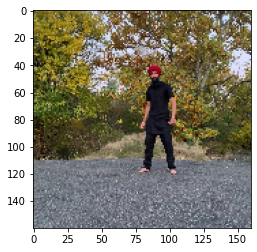

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


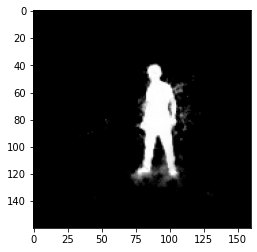

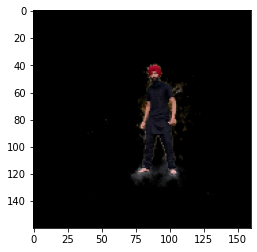

In [9]:
show_img(test_imgs_cropped[0])
show_img(output[0])
show_img(output[0]*test_imgs_cropped[0])


In [14]:
vid_path = "/content/gdrive/MyDrive/Colab Notebooks/Green Screen/Datasets/Test/videos/IMG_0857_1080p.mov"

In [15]:
vid_frames, bg_frame = get_video_frames(vid_path, skip_frames=5)

100%|██████████| 213/213 [00:18<00:00, 11.49it/s]


In [18]:
outputs = []
for img in tqdm(vid_frames):
    outputs.append(model.predict([img.reshape((1,160,160,3)), bg_frame.reshape((1,160,160,3))])[0])

100%|██████████| 213/213 [00:16<00:00, 13.04it/s]


In [59]:
# vid_orig = np.array(vid_frames[150:170])
# mask = np.array(outputs[150:170])
vid_orig = np.array(vid_frames[20:100])
mask = np.array(outputs[20:100])
mask = np.clip(mask, 0, 1)
mask_show = np.repeat(mask, 3, axis=-1)
video1 = vid_orig * mask
video_thresh1 = vid_orig * (mask > 0.7)
video_thresh2 = vid_orig * (mask > 0.9)

# np array with shape (frames, height, width, channels)
video_concat = np.concatenate((vid_orig, mask_show, video1, video_thresh1, 
                               video_thresh2), axis=2)
show_video(video_concat, framerate=5, figsize=(12,3))